<a href="https://colab.research.google.com/github/viibhutisharma30/Churn_Prediction_in_E-commerce_Project/blob/main/Copy_of_Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Data Inspection & Preprocessing**

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("events.csv")

# Inspect data
print("Data Shape:", data.shape)
print("Data Sample:")
print(data.head())

# Parse event_time
data['event_time'] = pd.to_datetime(data['event_time'])

# Handle missing values
data['brand'] = data['brand'].fillna('Unknown')
data['category_code'] = data['category_code'].fillna('Unknown')

# Drop duplicates
data.drop_duplicates(inplace=True)

# Check for inconsistent entries
print("Data Summary:")
print(data.info())

print("Dataset cleaned and parsed successfully.")


Data Shape: (885129, 9)
Data Sample:
                event_time event_type  product_id          category_id  \
0  2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1  2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
2  2020-09-24 11:57:27 UTC       view      215454  2144415927158964449   
3  2020-09-24 11:57:33 UTC       view      635807  2144415923107266682   
4  2020-09-24 11:57:36 UTC       view     3658723  2144415921169498184   

                   category_code        brand   price              user_id  \
0          electronics.telephone          NaN   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2                            NaN          NaN    9.81  1515915625513238515   
3  computers.peripherals.printer       pantum  113.81  1515915625519014356   
4                            NaN  cameronsino   15.87  1515915625510743344   

  user_session  
0   LJuJVLEjPT  
1   tdicluNnRY 

# **Step 2: Exploratory Data Analysis (EDA)**

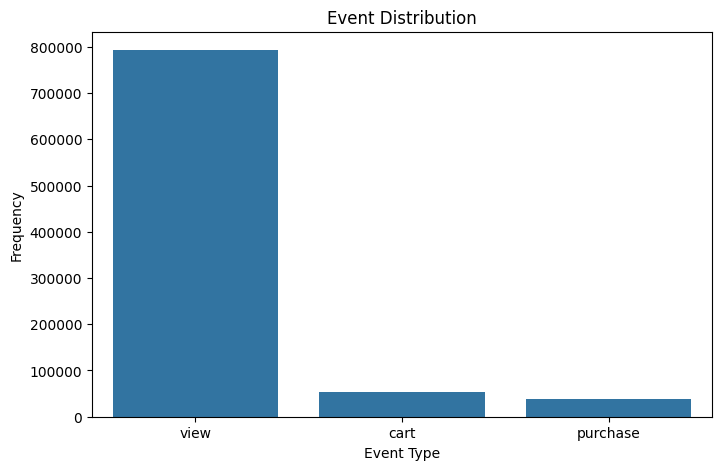

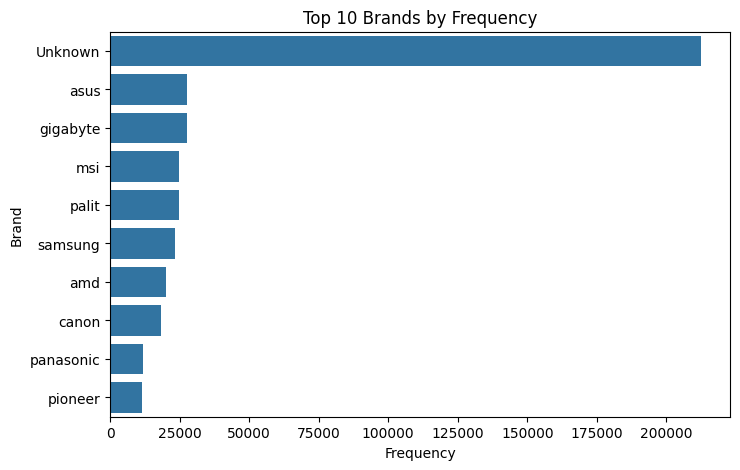

         total_spend    visit_count    active_days
count  407283.000000  407283.000000  407283.000000
mean      317.780159       2.171645       1.225239
std      1327.647888       4.405437       7.983615
min         0.220000       1.000000       0.000000
25%        29.840000       1.000000       0.000000
50%        78.570000       1.000000       0.000000
75%       236.100000       2.000000       0.000000
max    209144.530000     572.000000     156.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Event distribution over time
event_distribution = data['event_type'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=event_distribution.index, y=event_distribution.values)
plt.title("Event Distribution")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.show()

# Brand popularity
top_brands = data['brand'].value_counts().head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Top 10 Brands by Frequency")
plt.xlabel("Frequency")
plt.ylabel("Brand")
plt.show()

# User-level summaries
user_summary = data.groupby('user_id').agg({
    'price': 'sum',  # Total spend
    'event_type': 'count',  # Frequency of visits
    'event_time': lambda x: (x.max() - x.min()).days  # Active days
}).rename(columns={'price': 'total_spend', 'event_type': 'visit_count', 'event_time': 'active_days'})
print(user_summary.describe())


# **Step 3: Defining Churn**

In [ ]:
# Define churn as users who haven't made a purchase in the last 30 days
last_event_date = data['event_time'].max()
user_last_purchase = data[data['event_type'] == 'purchase'].groupby('user_id')['event_time'].max()
user_last_purchase = user_last_purchase.apply(lambda x: (last_event_date - x).days)

# Add churn label
user_churn = pd.DataFrame(user_last_purchase).rename(columns={'event_time': 'days_since_last_purchase'})
user_churn['churn'] = user_churn['days_since_last_purchase'].apply(lambda x: 1 if x > 30 else 0)
print("Churn Label Distribution:")
print(user_churn['churn'].value_counts())


Churn Label Distribution:
churn
1    16557
0     4747
Name: count, dtype: int64


# **Step 4: Feature Engineering**


In [ ]:
# Add features like total spend, visit count, active days, and average session value
user_features = user_summary.merge(user_churn, left_index=True, right_index=True)

# Example of a meaningful feature
user_features['avg_spend_per_visit'] = user_features['total_spend'] / user_features['visit_count']
user_features.fillna(0, inplace=True)

print("Feature Engineering Completed. Sample Data:")
print(user_features.head())


Feature Engineering Completed. Sample Data:
                     total_spend  visit_count  active_days  \
user_id                                                      
1515915625353286099      1111.83           11           20   
1515915625353457259       165.48            3            0   
1515915625353534622       190.50           10            9   
1515915625353561691      1685.74           10            0   
1515915625353900095      3986.57           40           20   

                     days_since_last_purchase  churn  avg_spend_per_visit  
user_id                                                                    
1515915625353286099                       148      1           101.075455  
1515915625353457259                       152      1            55.160000  
1515915625353534622                       145      1            19.050000  
1515915625353561691                        95      1           168.574000  
1515915625353900095                       136      1            9

# **Step 5: Modeling and Evaluation**

Train-test split completed.
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Model Evaluation Metrics:
ROC AUC Score: 1.0
Accuracy: 0.8573216520650814
Precision: 0.8448979591836735
Recall: 1.0
F1 Score: 0.9159292035398231
Log Loss: 0.2921374168349558

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      1424
           1       0.84      1.00      0.92      4968

    accuracy                           0.86      6392
   macro avg       0.92      0.68      0.72      6392
weighted avg       0.88      0.86      0.83      6392



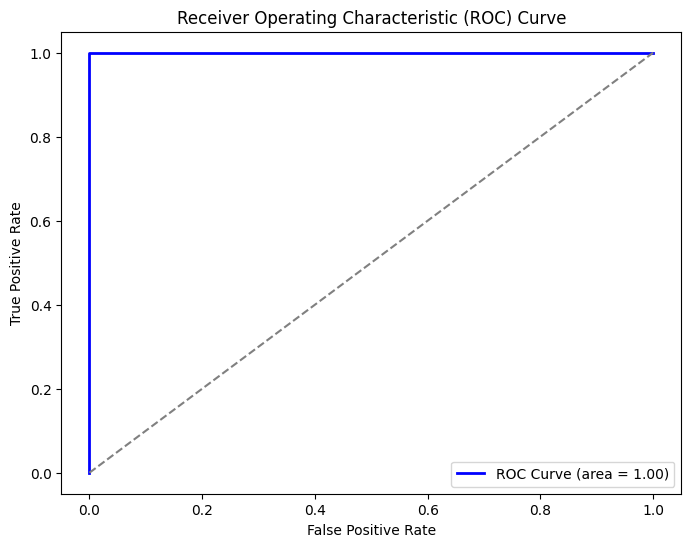

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_score,
    recall_score, f1_score, accuracy_score, log_loss
)

# Step 5: Train-Test Split
X = user_features.drop(columns=['churn'])
y = user_features['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train-test split completed.")

# Step 6: Hyperparameter Tuning Using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 7: Evaluate the Model
# Predictions
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Model Evaluation Metrics:")
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_pred_proba))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
pip install scikit-learn==1.0.2


In [ ]:
pip install --upgrade xgboost


# **Step 6: Interpretation & Explanation**

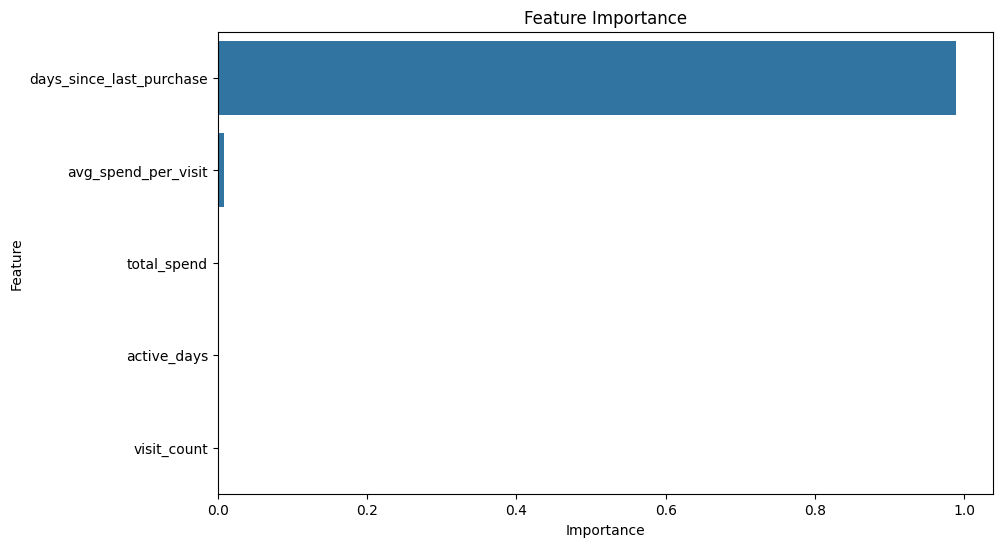

In [ ]:
# Feature Importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Feature Importance")
plt.show()
